In [7]:
from src.Base.Evaluation.Evaluator import EvaluatorHoldout
import numpy as np
from src.Utils.load_ICM import load_ICM
from src.Utils.load_URM import load_URM

import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

URM_all = load_URM("in/data_train.csv")
ICM_all = load_ICM("in/data_ICM_title_abstract.csv")

from src.Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage=0.80)

In [8]:
from src.Utils.ICM_preprocessing import *
from src.GraphBased.P3alphaRecommender import P3alphaRecommender
from src.GraphBased.RP3betaCBFRecommender import RP3betaCBFRecommender
from src.Hybrid.SimilarityMergedHybridRecommender import SimilarityMergedHybridRecommender
from src.Base.NonPersonalizedRecommender import TopPop
from src.MatrixFactorization.PureSVDRecommender import PureSVDItemRecommender
from src.EASE_R.EASE_R_Recommender import EASE_R_Recommender
ICM_combined = combine(ICM=ICM_all, URM = URM_train)

p3alpha_recommender = P3alphaRecommender(URM_train=URM_train)
p3alpha_recommender.fit(topK=221,alpha=0.5017,implicit=True)

rp3betaCBF_recommender = RP3betaCBFRecommender(URM_train=URM_train, ICM_train=ICM_combined)
rp3betaCBF_recommender.fit(topK=586, alpha=0.4228, beta=0.1918, implicit=False)

p3alpha_featurecombinedrp3beta_recommender = SimilarityMergedHybridRecommender(
    URM_train=URM_train,
    CFRecommender=p3alpha_recommender,
    CBFRecommender=rp3betaCBF_recommender
)
p3alpha_featurecombinedrp3beta_recommender.fit(topK=355, alpha=0.2222)

#pureSVDitem_recommender = PureSVDItemRecommender(URM_train)
#pureSVDitem_recommender.fit(num_factors=448,topK=462)

easer_recommender = EASE_R_Recommender(URM_train, sparse_threshold_quota=1.0)
easer_recommender.fit(**{"l2_norm": 41476.92126107723, "topK": 56})

topPop = TopPop(URM_train)
topPop.fit()

P3alphaRecommender: URM Detected 64 (0.81 %) cold users.
P3alphaRecommender: URM Detected 2378 (9.15 %) cold items.
RP3betaCBFRecommender: URM Detected 64 (0.81 %) cold users.
RP3betaCBFRecommender: URM Detected 2378 (9.15 %) cold items.
RP3betaRecommender: URM Detected 66 (0.24 %) cold users.
P3alphaRP3betaCBFHybridRecommender: URM Detected 64 (0.81 %) cold users.
P3alphaRP3betaCBFHybridRecommender: URM Detected 2378 (9.15 %) cold items.
EASE_R_Recommender: URM Detected 64 (0.81 %) cold users.
EASE_R_Recommender: URM Detected 2378 (9.15 %) cold items.
EASE_R_Recommender: Fitting model... 
Similarity column 25975 ( 100 % ), 10904.92 column/sec, elapsed time 0.04 min
EASE_R_Recommender: Fitting model... done in 8.32 min
EASE_R_Recommender: Detected model matrix to be sparse, changing format.
TopPopRecommender: URM Detected 64 (0.81 %) cold users.
TopPopRecommender: URM Detected 2378 (9.15 %) cold items.


In [9]:
profile_length = np.ediff1d(URM_train.indptr)
block_size = int(len(profile_length)*0.1)
sorted_users = np.argsort(profile_length)


In [10]:
for group_id in range(0, 10):

    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    print("Group {}, average p.len {:.2f}, min {}, max {}".format(group_id,
        users_in_group_p_len.mean(), users_in_group_p_len.min(), users_in_group_p_len.max()))

Group 0, average p.len 1.13, min 0, max 2
Group 1, average p.len 2.00, min 2, max 2
Group 2, average p.len 2.64, min 2, max 3
Group 3, average p.len 3.24, min 3, max 4
Group 4, average p.len 4.18, min 4, max 5
Group 5, average p.len 5.44, min 5, max 6
Group 6, average p.len 6.87, min 6, max 8
Group 7, average p.len 9.78, min 8, max 12
Group 8, average p.len 16.26, min 12, max 22
Group 9, average p.len 56.19, min 22, max 422


In [11]:
MAP_hybrid_per_group = []
MAP_p3alpha_per_group = []
MAP_featurecombinationRP3beta_per_group = []
MAP_pureSVDitem_per_group = []
MAP_easer_per_group = []
MAP_topPop_per_group = []
cutoff = 10

for group_id in range(0, 10):

    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    print("Group {}, average p.len {:.2f}, min {}, max {}".format(group_id,
        users_in_group_p_len.mean(), users_in_group_p_len.min(), users_in_group_p_len.max()))


    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert = True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users = users_not_in_group)


    results, _ = evaluator_test.evaluateRecommender(p3alpha_featurecombinedrp3beta_recommender)
    MAP_hybrid_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_test.evaluateRecommender(p3alpha_recommender)
    MAP_p3alpha_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_test.evaluateRecommender(rp3betaCBF_recommender)
    MAP_featurecombinationRP3beta_per_group.append(results[cutoff]["MAP"])

    #results, _ = evaluator_test.evaluateRecommender(pureSVDitem_recommender)
    #MAP_pureSVDitem_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_test.evaluateRecommender(easer_recommender)
    MAP_easer_per_group.append(results[cutoff]["MAP"])


    results, _ = evaluator_test.evaluateRecommender(topPop)
    MAP_topPop_per_group.append(results[cutoff]["MAP"])



Group 0, average p.len 1.13, min 0, max 2
EvaluatorHoldout: Ignoring 7153 Users
EvaluatorHoldout: Processed 647 ( 100.00% ) in 0.97 sec. Users per second: 670
EvaluatorHoldout: Processed 647 ( 100.00% ) in 0.46 sec. Users per second: 1413
EvaluatorHoldout: Processed 647 ( 100.00% ) in 1.02 sec. Users per second: 633
EvaluatorHoldout: Processed 647 ( 100.00% ) in 0.35 sec. Users per second: 1827
EvaluatorHoldout: Processed 647 ( 100.00% ) in 0.49 sec. Users per second: 1319
Group 1, average p.len 2.00, min 2, max 2
EvaluatorHoldout: Ignoring 7153 Users
EvaluatorHoldout: Processed 396 ( 100.00% ) in 0.34 sec. Users per second: 1179
EvaluatorHoldout: Processed 396 ( 100.00% ) in 0.22 sec. Users per second: 1782
EvaluatorHoldout: Processed 396 ( 100.00% ) in 0.44 sec. Users per second: 900
EvaluatorHoldout: Processed 396 ( 100.00% ) in 0.22 sec. Users per second: 1832
EvaluatorHoldout: Processed 396 ( 100.00% ) in 0.31 sec. Users per second: 1276
Group 2, average p.len 2.64, min 2, max 3
E

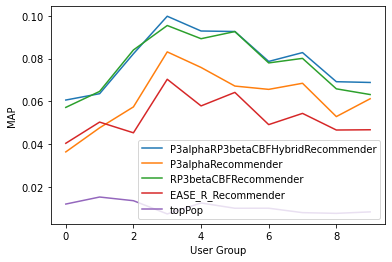

In [12]:
import matplotlib.pyplot as pyplot
%matplotlib inline

pyplot.plot(MAP_hybrid_per_group, label=p3alpha_featurecombinedrp3beta_recommender.RECOMMENDER_NAME)
pyplot.plot(MAP_p3alpha_per_group, label=p3alpha_recommender.RECOMMENDER_NAME)
pyplot.plot(MAP_featurecombinationRP3beta_per_group, label=RP3betaCBFRecommender.RECOMMENDER_NAME)
#pyplot.plot(MAP_pureSVDitem_per_group, label=pureSVDitem_recommender.RECOMMENDER_NAME)
pyplot.plot(MAP_easer_per_group, label=easer_recommender.RECOMMENDER_NAME)
pyplot.plot(MAP_topPop_per_group, label="topPop")
pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()


